<a href="https://colab.research.google.com/github/KyoHoon998/hello-world/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-12-13 12:57:56--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.7.12=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libedit==3.1.20181209=hc058e9b_0
  

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [29]:
import os
import pandas as pd
import numpy as np
import scipy
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

try:

    %tensorflow_version 1.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

import tensorflow

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [30]:
smifile = "GDB4c.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print (smiles_train.shape)
print (smiles_test.shape)

(710163,)
(236721,)


In [0]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)

In [0]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5


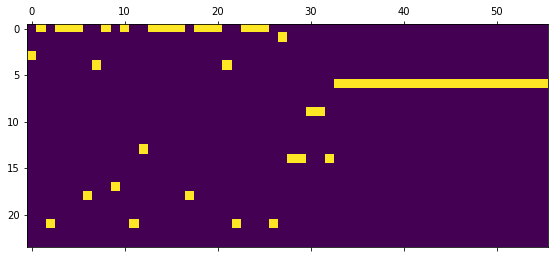

In [33]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
plt.matshow(X_train[0].T)

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [0]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

In [39]:
from tensorflow.keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=2,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Train on 710163 samples, validate on 236721 samples
Epoch 1/2
710163/710163 [==============================] - 453s 637us/sample - loss: 0.5142 - val_loss: 0.4570
Epoch 2/2
710163/710163 [==============================] - 444s 625us/sample - loss: 0.4231 - val_loss: 0.3986


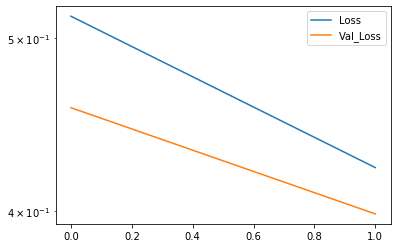

In [42]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [43]:
for i in range(10):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)

C1CCCCCC2CC2C2(CCCCC1)CCC1CCCC1CC2 776463EEEEEEEEEEEEEE C1CCCC222CCCCCCCCCCC1)CCCCCCCCCCC2 887407EEEEEEEEEEEEEE
C1CCC2CCC(C2)C2CC(C2)C2(CC1)CCCC2 256765EEEEEEEEEEEEEEE C1CCCCCCCCC2)C2CCCCC)CCCCC1)CCCC2 282777EEEEEEEEEEEEEEE
C1CCCCC2(CCC3CCC3CCC1)C1CCCCC2CC1 736130EEEEEEEEEEEEEEE C1CCCCC2CCCC3CCCCCCC1)CCCCCCCCCC1 757270EEEEEEEEEEEEEEE
c1ccc2c(c1)CCCC1(CCC2)CCC2CCC2C1 425415EEEEEEEEEEEEEEEE c1ccc2c(c1)CCCCCCCCCC)CCC2CCC2C1 455000EEEEEEEEEEEEEEEE
C1CCCC2CCCC3CC(CCC1)C2C31CCC1 302651EEEEEEEEEEEEEEEEEEE C1CCC22CCCC3CC2CC11)CCCC1CCC1 300500EEEEEEEEEEEEEEEEEEE
C1CCCCC23CCC2C2(CCC1)CCC3CC2 214970EEEEEEEEEEEEEEEEEEEE C1CCCC223CCC2CCCCCCC)CCCCCC2 214000EEEEEEEEEEEEEEEEEEEE
C1CCCCC2(CCCC1)CC13CCCC1CCCCC23 456453EEEEEEEEEEEEEEEEE C1CCCC22CCCCC1)CC1CCCCCCCCCCC23 477700EEEEEEEEEEEEEEEEE
c1ccc2c(c1)CCC1(CCCCCC1)CCCCCC1CCC21 791301EEEEEEEEEEEE c1ccc2c(c1)CCCC(CCCCCCC)CCCCCCCCCC21 872111EEEEEEEEEEEE
C1CCC2(CC1)CCCC1CC3CC(CCC2)C(C1)C3 361962EEEEEEEEEEEEEE C1CCCCCCC1)CCCC1CC3(CCCCCC)CCC1)C3 350711EEEEEEE

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [0]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [0]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [0]:
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

In [49]:
sample_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(1, 1, 24)]              0         
_________________________________________________________________
lstm_4 (LSTM)                (1, 1, 64)                22784     
_________________________________________________________________
dense_8 (Dense)              (1, 1, 24)                1560      
Total params: 24,344
Trainable params: 24,344
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_latent = smiles_to_latent_model.predict(X_test)

[     5 216189  59547  40587 143468  16596 218615  26106  87936 201966]
245114    C1CCCCC23CCC2C2(CCC1)CCC3CC2 214970
261443    C1CCC2CC3CCC(C1)CC3CC1CCCC21 231329
245778    C1CCCC2C3CCC(CCC3CC1)C21CCC1 215634
260212    C1CC2CCC3(CCCCC2C3)CC2CCC2C1 230094
248534    C1CCCCC23CC(CCC1)C2CCC31CCC1 218390
218094    C1CCCCC23CC2CCC(CCC1)C1CCC13 187932
221101    C1CCC2CC3CCC2C(C1)CCCC1CC1C3 190940
218259    C1CCCCC23CC(CCC1)CC21CCCC3C1 188097
Name: smiles, dtype: object


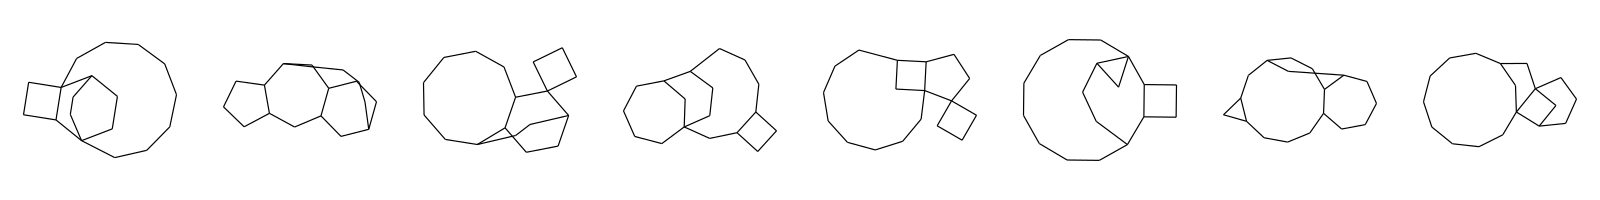

In [53]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print (sorti[0:10])
print (smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

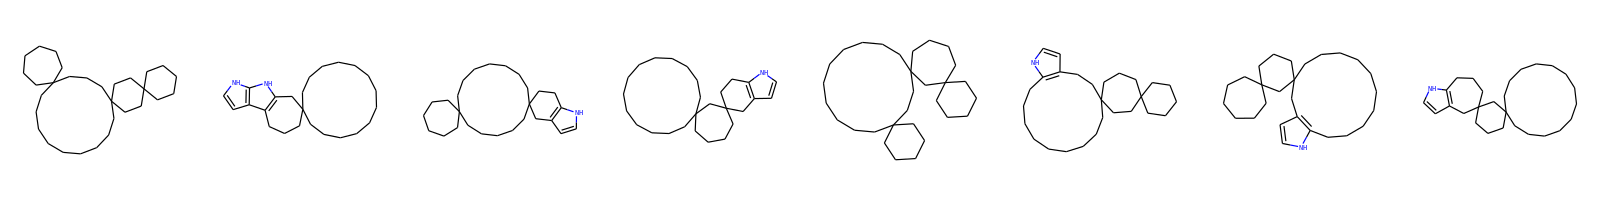

In [54]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.84281192 0.1201985 ] 0.9630104161452597


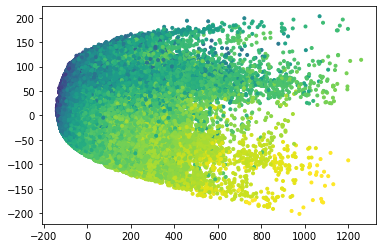

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

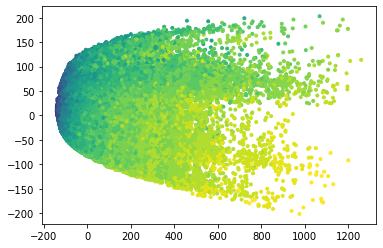

In [57]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [0]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)


In [0]:
from tensorflow.keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

In [0]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=10, callbacks = [rlr])

In [0]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,24))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,24))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
smiles = latent_to_smiles(x_latent[0:1])
print (smiles)
print (smiles_test.iloc[0])

In [0]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print (smiles)
        wrong = wrong + 1
print ("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

In [0]:
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print smiles
Draw.MolsToGridImage(mols1, molsPerRow=5)

In [0]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print smiles
Draw.MolsToGridImage(mols, molsPerRow=5)
